In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import cupy,tqdm # CUDA interface for python
%load_ext autoreload
%autoreload 2
%load_ext autotime

In [2]:
a = sciIO.readsav('../TD4.sav')
print(a.keys())

dict_keys(['bx', 'by', 'bz', 'xreg_kt', 'yreg_kt', 'zreg_kt', 'resolution'])
time: 1.04 s


In [3]:
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.bx,(2,1,0)).astype(np.float32)
By = np.transpose(a.by,(2,1,0)).astype(np.float32)
Bz = np.transpose(a.bz,(2,1,0)).astype(np.float32)
(Bx_gpu,By_gpu,Bz_gpu) = [np.zeros(0) for _ in range(3)]; flag_init=False
#plt.imshow(Bz[:,:,50].T) 

time: 606 ms


In [4]:
import os
print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBlineAdaptive.cu", "rt")
TraceFunc =cupy.RawModule(code=traceFunc_file.read(),backend='nvcc',options=("-I "+PWD,))#, include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBline = TraceFunc.get_function("TraceAllBline")

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = cupy.array(Bx)
    By_gpu = cupy.array(By)
    Bz_gpu = cupy.array(Bz)

dummy=cupy.zeros([1,1],dtype=cupy.float32)
dummy64=cupy.zeros([1,1],dtype=cupy.float64)
flag_twist=cupy.array([True],dtype=cupy.bool_)
flag_twist_false=cupy.array([False],dtype=cupy.bool_)

compiling kernel
transfering B-field to GPU
time: 5.67 s


In [5]:
Bz_gpu.shape

(501, 501, 501)

time: 3.03 ms


In [6]:
# calc curl(B)
curBx_gpu = cupy.zeros_like(Bx_gpu)
curBy_gpu = cupy.zeros_like(By_gpu)
curBz_gpu = cupy.zeros_like(Bz_gpu)

curBx_gpu[:,1:-1,1:-1] = ((Bz_gpu[:,2:,  1:-1]-Bz_gpu[:,0:-2,1:-1])/2.
                         -(By_gpu[:,1:-1,2:]-  By_gpu[:,1:-1,0:-2])/2)
curBy_gpu[1:-1,:,1:-1] = ((Bx_gpu[1:-1,:,2:]-  Bx_gpu[1:-1,:,0:-2])/2.
                         -(Bz_gpu[2:,  :,1:-1]-Bz_gpu[0:-2,:,1:-1])/2)
curBz_gpu[1:-1,1:-1,:] = ((By_gpu[2:,  1:-1,:]-By_gpu[0:-2,1:-1,:])/2.
                         -(Bx_gpu[1:-1,2:,  :]-Bx_gpu[1:-1,0:-2,:])/2)


# take care of z=0
curBx_gpu[1:-1,1:-1,0] = ((Bz_gpu[1:-1,2:,  0]-Bz_gpu[1:-1,0:-2,0])/2.
                         -(-3.*By_gpu[1:-1,1:-1,0]+4.*By_gpu[1:-1,1:-1,1]-By_gpu[1:-1,1:-1,2])/2)
curBy_gpu[1:-1,1:-1,0] = ((-3.*Bx_gpu[1:-1,1:-1,0]+4.*Bx_gpu[1:-1,1:-1,1]-Bx_gpu[1:-1,1:-1,2])/2.
                         -(Bz_gpu[2:,  1:-1,0]-Bz_gpu[0:-2,1:-1,0])/2)

time: 1.06 s


(200, 300)

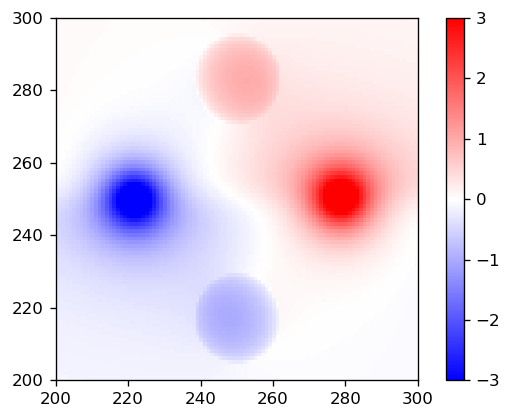

time: 276 ms


In [260]:
plt.figure(dpi=120)
plt.imshow(Bz_gpu[250,:,:].get().T,origin='lower',vmax=3,vmin=-3,cmap='bwr')
plt.colorbar()
plt.xlim([200,300])
plt.ylim([200,300])

In [8]:
curBx_gpu.shape

(501, 501, 501)

time: 3.01 ms


(-1e-05, 1e-05)

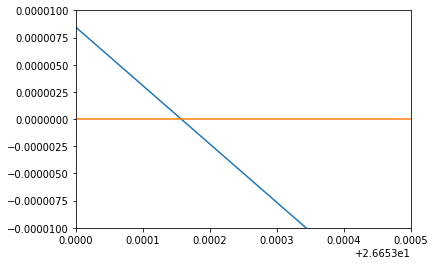

time: 193 ms


In [312]:
plt.plot(Bx_gpu[250,250,0:40].get())
plt.plot([0,40],[0,0])
plt.xlim([26.653,26.6535])
plt.ylim([-1e-5,1e-5])

In [309]:
import FastQSL
# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
print(BshapeN)
BshapeN = cupy.array(BshapeN)

interp_ratio=8
stride_step=1/interp_ratio
x_range = [0,1163]
y_range = [0,487]
x_range = [220,280]
y_range = [200,300]
z_range = [0,55]

x_i = cupy.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=cupy.float32)
y_i = cupy.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=cupy.float32)
z_i = cupy.linspace(*z_range, np.uint(interp_ratio*(z_range[1]-z_range[0])),dtype=cupy.float32)

x_arr,y_arr = cupy.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten()
y_inp = y_arr.flatten()

#z_inp[:] = +23.583333

if not flag_init:
    (x_start,y_start,z_start, x_end,y_end,z_end,
     Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    flag_init=True

line_len = cupy.zeros(x_inp.shape,cupy.float64)
N        = cupy.array([x_inp.shape[0]],cupy.ulonglong)
s_len    = cupy.array([1./8.],cupy.float32)
tol_coef    = cupy.array([0.1],cupy.float32)


inp_norm = cupy.array([0,0,1.],cupy.float32)

twist_all = cupy.zeros(x_inp.shape,cupy.float64)

# for GTX 1060
#blck=(64,1,1)
#grd = (20,1)

# for GTX1080ti
blck=(128,1,1)
grd = (28,1)
cupy.cuda.stream.get_current_stream().synchronize()

[501 501 501]
time: 11 ms


In [38]:
Qube=np.zeros([*xy_shape,z_i.shape[0]],dtype=np.float32)
Twube=np.zeros([*xy_shape,z_i.shape[0]],dtype=np.float32)
Liube=np.zeros([*xy_shape,z_i.shape[0]],dtype=np.float32)
#z_i=z_i*0+20

B0z = np.zeros(x_arr.shape,dtype=np.float32)

time: 2.99 ms


In [39]:
line_len.shape

(384000,)

time: 3 ms


In [40]:
pinned_mempool = cupy.get_default_pinned_memory_pool()
for idx_pos_z,z_pos in tqdm.tqdm(enumerate(z_i)):
    
    x_inp = x_arr.flatten()
    y_inp = y_arr.flatten()
    z_inp = (cupy.zeros_like(x_inp,cupy.float32)+z_pos)
    
    (x_start,y_start,z_start, x_end,y_end,z_end,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    
    cupy.cuda.stream.get_current_stream().synchronize()
    # run the big calclation
    TraceAllBline(blck,grd,
                (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
                curBx_gpu,curBy_gpu,curBz_gpu,twist_all,flag_twist,
                x_inp,   y_inp,   z_inp,inp_norm,
                x_start, y_start, z_start, flag_start,
                x_end,   y_end,   z_end,   flag_end,
                Bx_inp,  By_inp,  Bz_inp,  B_flag,
                Bx_start,By_start,Bz_start,
                Bx_end,  By_end,  Bz_end,  
                s_len,N,line_len, tol_coef))
    cupy.cuda.stream.get_current_stream().synchronize()
    (x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
     x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
     Bx_in_arr,   By_in_arr,  Bz_in_arr,
     Bx_out_arr,  By_out_arr, Bz_out_arr,
     Bx_0_arr,    By_0_arr,   Bz_0_arr,   B_flag_arr, twist_all_arr,
     line_len_arr) = FastQSL.ResReshape(xy_shape,
                    x_end,y_end,z_end,flag_end,
                    x_start,y_start,z_start,flag_start,
                    Bx_start,By_start,Bz_start,
                    Bx_end,By_end,Bz_end, 
                    Bx_inp,By_inp,Bz_inp,B_flag,twist_all,line_len)
    
    if z_pos<1e-5:
        B0z=Bz_0_arr.get()
    
    cupy.cuda.stream.get_current_stream().synchronize()
    Q=FastQSL.QCalcPlane(x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
         x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
         Bx_in_arr,   By_in_arr,  Bz_in_arr,
         Bx_out_arr,  By_out_arr, Bz_out_arr,
         Bx_0_arr,    By_0_arr,   Bz_0_arr,    
         B_flag_arr, stride_step)
    stride_this  =  cupy.float32(1./interp_ratio)/8

    (cut_inp_x,   cut_inp_y,   cut_inp_z,
        cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
        cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
        Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
        Bx_start_cut,By_start_cut,Bz_start_cut,
        Bx_end_cut,  By_end_cut,  Bz_end_cut,  
        N_cut,line_len_cut,Bz0_start, Bz0_end)=FastQSL.CookPseudoLine(
             x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
             x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
             Bx_in_arr,   By_in_arr,  Bz_in_arr,
             Bx_out_arr,  By_out_arr, Bz_out_arr,
             Bz_0_arr,    B_flag_arr, stride_this)
    
    cupy.cuda.stream.get_current_stream().synchronize()
    TraceAllBline(blck,grd,
            (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
              dummy,dummy,dummy,dummy64,flag_twist_false,
            cut_inp_x,   cut_inp_y,   cut_inp_z,inp_norm,
            cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
            cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
            Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
            Bx_start_cut,By_start_cut,Bz_start_cut,
            Bx_end_cut,  By_end_cut,  Bz_end_cut,  
            s_len,N_cut,line_len_cut, tol_coef*.1))
    
    
    cupy.cuda.stream.get_current_stream().synchronize()
    (X1,Y1,X2,Y2) = [cupy.zeros(cut_inp_x.shape,dtype=cupy.float32) 
                     for _ in range(4)];

    idx_Z1_cut=(flag_cut_start-1)//2 == 2;  idx_Z2_cut=(flag_cut_end-1)//2 == 2
    idx_Y1_cut=(flag_cut_start-1)//2 == 1;  idx_Y2_cut=(flag_cut_end-1)//2 == 1
    idx_X1_cut=(flag_cut_start-1)//2 == 0;  idx_X2_cut=(flag_cut_end-1)//2 == 0

    
    cupy.cuda.stream.get_current_stream().synchronize()
    # Z plane
    X1[idx_Z1_cut] = cut_start_x[idx_Z1_cut]; Y1[idx_Z1_cut] = cut_start_y[idx_Z1_cut] 
    X2[idx_Z2_cut] = cut_end_x[idx_Z2_cut];   Y2[idx_Z2_cut] = cut_end_y[idx_Z2_cut] 
    # Y plane
    X1[idx_Y1_cut] = cut_start_z[idx_Y1_cut]; Y1[idx_Y1_cut] = cut_start_x[idx_Y1_cut]
    X2[idx_Y2_cut] = cut_end_z[idx_Y2_cut];   Y2[idx_Y2_cut] = cut_end_x[idx_Y2_cut]
    # X plane
    X1[idx_X1_cut] = cut_start_y[idx_X1_cut]; Y1[idx_X1_cut] = cut_start_z[idx_X1_cut]
    X2[idx_X2_cut] = cut_end_y[idx_X2_cut];   Y2[idx_X2_cut] = cut_end_z[idx_X2_cut]

    dx2xc = X2[0::4]-X2[2::4]; dx2yc = X2[1::4]-X2[3::4];
    dy2xc = Y2[0::4]-Y2[2::4]; dy2yc = Y2[1::4]-Y2[3::4];
    dx1xc = X1[0::4]-X1[2::4]; dx1yc = X1[1::4]-X1[3::4];
    dy1xc = Y1[0::4]-Y1[2::4]; dy1yc = Y1[1::4]-Y1[3::4];
    a_cut = (dx2xc*dy1yc-dx2yc*dy1xc);
    b_cut = (dx2yc*dx1xc-dx2xc*dx1yc);
    c_cut = (dy2xc*dy1yc-dy2yc*dy1xc);
    d_cut = (dy2yc*dx1xc-dy2xc*dx1yc);

    bnr_cut = cupy.abs(Bz0_end)/(cupy.abs(Bz0_start))*((1/stride_this/2)**4)
    Qcut = (a_cut**2+b_cut**2+c_cut**2+d_cut**2)*bnr_cut
    Qcut[cupy.where(Qcut<1.0)]=1.0
    
    Q_all=cupy.zeros(x_end_arr.shape,dtype=cupy.float32)
    Q_all[1:-1,1:-1]=Q
    Q_all[B_flag_arr==1]=Qcut
    
    Qube[:,:,idx_pos_z]=Q_all.get()
    Twube[:,:,idx_pos_z]=twist_all_arr.get()
    Liube[:,:,idx_pos_z]=line_len_arr.get()
    
    cupy.cuda.stream.get_current_stream().synchronize()
    
    (x_start,y_start,z_start, x_end,y_end,z_end,z_inp,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[None for _ in range(16)]
    (B_flag,flag_start,flag_end)=[None for _ in range(3)]
    pinned_mempool.free_all_blocks()

440it [03:22,  2.18it/s]

time: 3min 22s


In [41]:
import plotly
x_i_0 = np.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=np.float32)
y_i_0 = np.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=np.float32)
z_i_0 = np.linspace(*z_range, np.uint(interp_ratio*(z_range[1]-z_range[0])),dtype=np.float32)

x_arr_0,y_arr_0,z_arr_0 = np.meshgrid(x_i_0, y_i_0, z_i_0)

time: 2.54 s


In [28]:
x_arr_0.shape

(800, 480, 440)

time: 1.98 ms


In [16]:
from numpy import cos, pi, mgrid
import pyvista as pv

time: 2.52 s


In [42]:
np.savez('../QubeFinal.npz', Qube=Qube,
         xi=x_arr_0,yi=y_arr_0,zi=z_arr_0,
         Twube=Twube,B0z=B0z)

time: 19.4 s


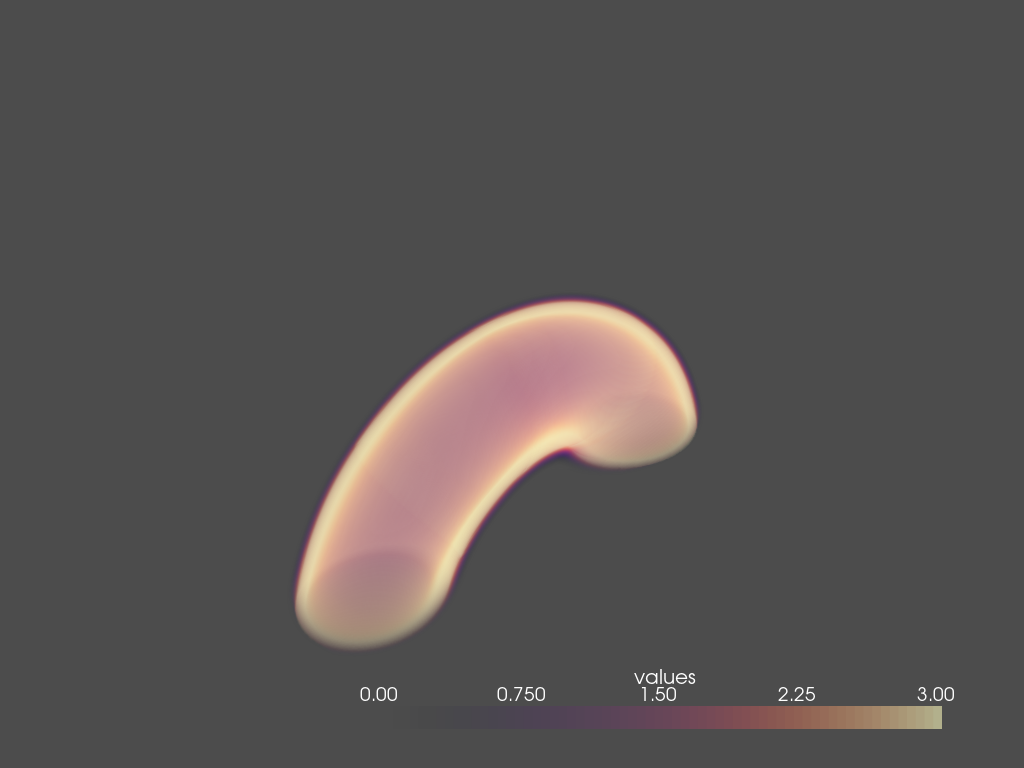

time: 11.7 s


In [47]:
opacity = [ 0,0.15,0.27, 0.4, 0.6]
clim = [0, 3]

p = pv.Plotter()
p.add_volume(Twube, cmap="magma", clim=clim,
             opacity=opacity, opacity_unit_distance=40,)
#p.camera_position = [(-800*2, 1200*2, 666*2),
# (179.5, 299.5, 99.5),
# (0.4, -0.1, 0.9)]
p.show()

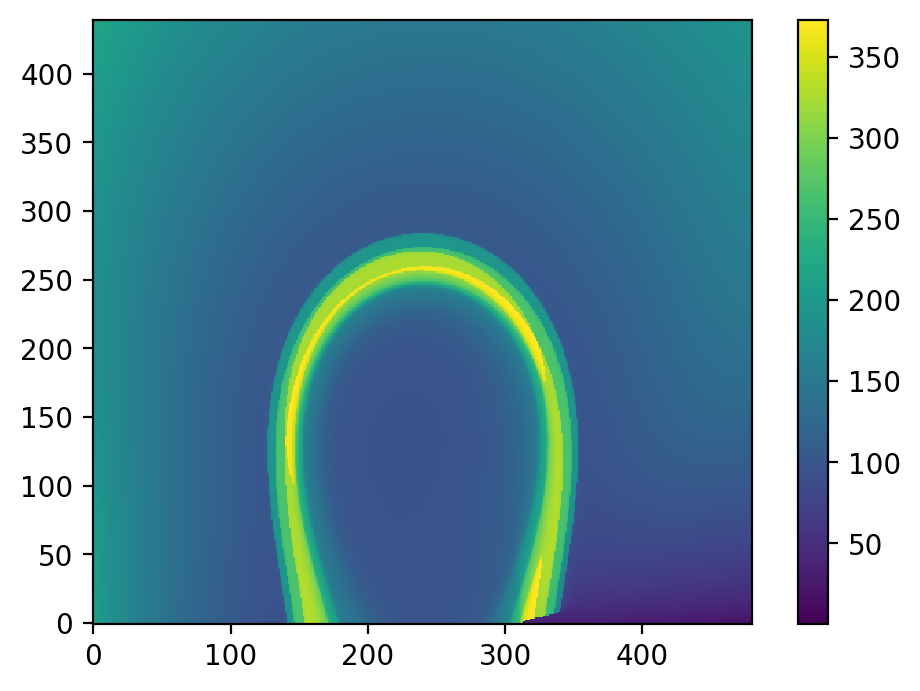

time: 427 ms


In [218]:
plt.figure(dpi=200)
plt.imshow((Liube[200,:,:].T),origin='lower')#,vmax=0.0001,vmin=-0.0001,cmap='bwr')
plt.colorbar()

In [151]:
Qube.shape

(800, 480, 440)

time: 3.01 ms


divide by zero encountered in log10


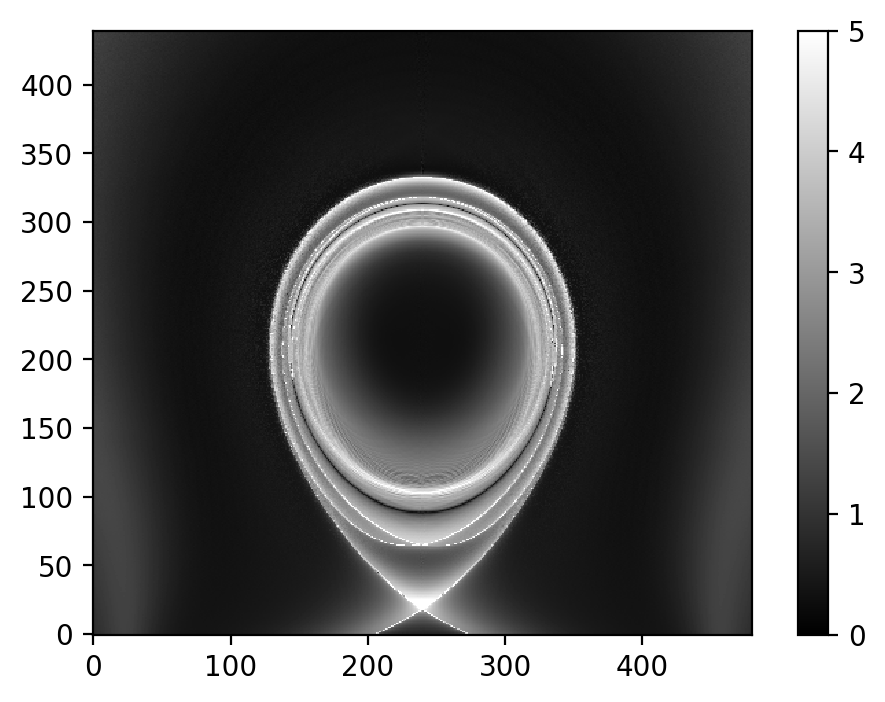

time: 582 ms


In [45]:
plt.figure(dpi=200)
#plt.imshow(np.log10(Qube[:,:,10])*np.sign(Bz_0_arr[:,:].get()),origin='lower',vmax=5,vmin=-5,cmap='bwr')
plt.imshow(np.nan_to_num(np.log10(Qube[400,:,:].T)),origin='lower',vmax=5,vmin=0,cmap='gray') # vertical

#plt.imshow(Twube[:,:,0],origin='lower',vmax=5,vmin=-5,cmap='bwr')
#plt.imshow(Twube[:,:,0].T,origin='lower',vmax=5,vmin=-5,cmap='bwr') # vertical
plt.colorbar()

In [ ]:
#%% Data
grid = pv.StructuredGrid(x_arr_0.flatten(), y_arr_0.flatten(), z_arr_0.flatten())
grid["vol"] = Qube.flatten()
contours = grid.contour([1000000])

#%% Visualization
pv.set_plot_theme('document')
p = pv.Plotter()
p.add_mesh(contours, scalars=contours.points[:, 2], show_scalar_bar=False)
p.show()

In [ ]:
plt.imshow()

In [ ]:
plt.close()

xxlim=None
yylim=None

#xxlim=[400,720]
#yylim=[150,400]
#xxlim=[550,650]
#yylim=[200,270]
#xxlim= [350,670]
#yylim= [200,400]

dpi=180

fig=plt.figure(0,dpi=dpi); ax = plt.gca() 
img=ax.imshow(flag_start_arr.get(),cmap='inferno',origin='lower',vmin=0,
              extent=[*x_range,*y_range],vmax=6)
fig.colorbar(img)
ax.set_title('flag')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(1,dpi=dpi); ax = plt.gca() 
img=ax.imshow((line_len.get().reshape(xy_shape)),cmap='inferno',origin='lower',
              vmin=0,extent=[*x_range,*y_range],vmax=1000)
fig.colorbar(img)
ax.set_title('Length of B-line')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_in_arr.get()/Bz_out_arr.get(),cmap='gray',origin='lower',
              vmax=10,vmin=-10,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_in')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_out_arr.get(),cmap='gray',origin='lower',vmax=1000,vmin=-1000,
              extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_out')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(4,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q.get())*np.sign(Bz_0_arr.get()[1:-1,1:-1])
                *(flag_start_arr.get()[1:-1,1:-1]<=6),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


fig=plt.figure(5,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q.get())*np.sign(Bz_0_arr.get()[1:-1,1:-1])
                *(flag_start_arr.get()[1:-1,1:-1]<=6),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(6,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q_all.get())*(flag_start_arr.get()[1:-1,1:-1]<41),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map-gray')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


In [ ]:
fig=plt.figure(1,dpi=180); ax = plt.gca() 
#img = ax.imshow(np.log((b.get())**2),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
#fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=180); ax = plt.gca() 
img = ax.imshow((B_flag_arr.get()),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


In [379]:
import MagTool as mt

time: 992 µs


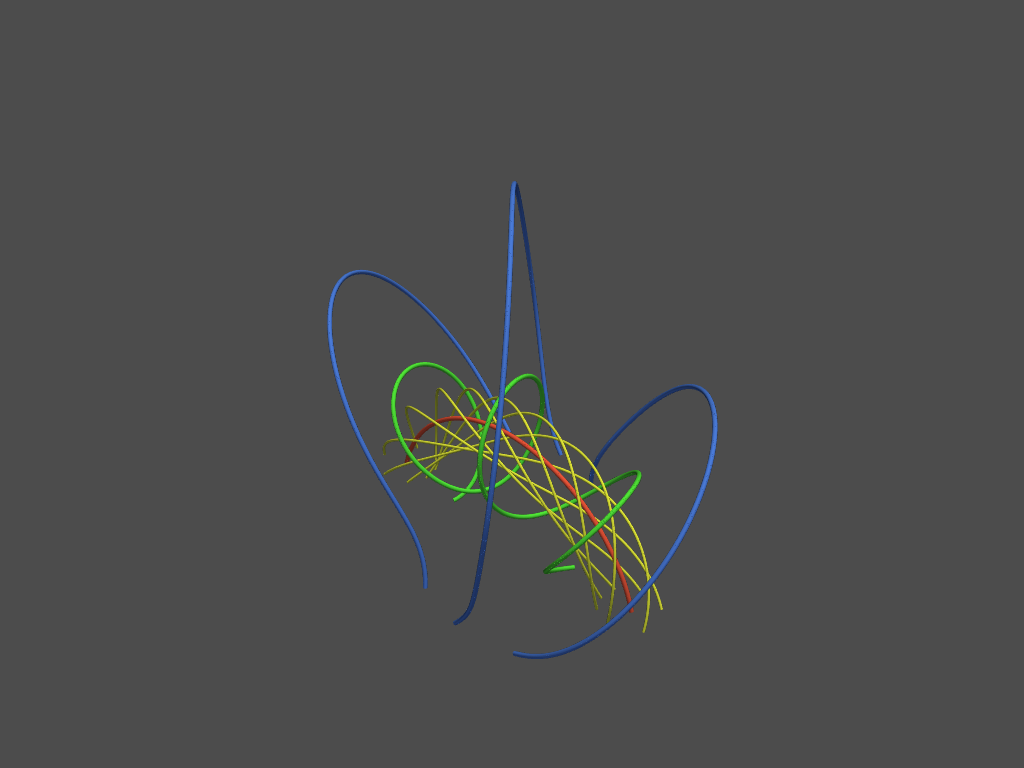

time: 4.33 s


In [381]:

p = pv.Plotter()



  
# twist
N_start=8
r=6.5
theta=np.linspace(0,2*np.pi,N_start)
x_start = 250+np.cos(theta)*r
z_start = np.sin(theta)*r
for idx in range(N_start):
    pthis = np.array([x_start[idx],250,z_start[idx]+26.533]).astype(np.float32)
    (lx,ly,lz)=mt.TraceBline(Bx,By,Bz,pthis,dr=0.25,maxstep=1e4)
    points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
    line = pv.lines_from_points(points)
    tube = line.tube(radius=0.3)
    p.add_mesh(tube,smooth_shading=True,color="#f4ff41")
    

# center
p0 = np.array([250,215.24,0],dtype=np.float32)
(lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
line = pv.lines_from_points(points)
tube = line.tube(radius=0.5)
p.add_mesh(tube,smooth_shading=True,color="#ff5e41")

# tube
p0 = np.array([250,250,40],dtype=np.float32)
(lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
line = pv.lines_from_points(points)
tube = line.tube(radius=0.5)
p.add_mesh(tube,smooth_shading=True,color="#58FF41")    

# cage
p0 = np.array([250,250,80],dtype=np.float32)
(lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
line = pv.lines_from_points(points)
tube = line.tube(radius=0.5)
p.add_mesh(tube,smooth_shading=True,color="#5189ff")    

    
p0 = np.array([250,200,45],dtype=np.float32)
(lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
line = pv.lines_from_points(points)
tube = line.tube(radius=0.5)
p.add_mesh(tube,smooth_shading=True,color="#5189ff")
    
p0 = np.array([250,300,45],dtype=np.float32)
(lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
line = pv.lines_from_points(points)
tube = line.tube(radius=0.5)
p.add_mesh(tube,smooth_shading=True,color="#5189ff")

p.show()


In [352]:
points[-1,:]

array([2.2825764e+02, 2.4413335e+02, 1.5511140e-03], dtype=float32)

time: 4 ms


In [157]:
lxall

array([200.     , 199.806  , 199.61246, 199.41939, 199.2268 , 199.03474,
       198.8432 , 198.65218, 198.46162, 198.27151, 198.08185, 197.89265,
       197.70392, 197.51567, 197.32791, 197.1406 , 196.95372, 196.76729,
       196.58134, 196.39589, 196.21095, 196.02649, 195.84248, 195.65894,
       195.47585, 195.29324, 195.11113, 194.92949, 194.74829, 194.56754,
       194.38724, 194.20741, 194.02806, 193.84917, 193.6707 , 193.49268,
       193.31511, 193.138  , 192.96135, 192.78514, 192.60938, 192.43405,
       192.25917, 192.08473, 191.91075, 191.7372 , 191.56409, 191.3914 ,
       191.21915, 191.04733, 190.87596, 190.70502, 190.5345 , 190.36441,
       190.19473, 190.02548, 189.85667, 189.6883 , 189.52032, 189.35277,
       189.18562, 189.0189 , 188.85263, 188.68678], dtype=float32)

time: 4 ms


 time: 4.02 ms


         3 function calls in 0.000 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}